<a href="https://colab.research.google.com/github/CodeCraftIA/odoo_api/blob/main/IAodooAPI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Το odoo-rpc package δεν χρειάστηκε, το μόνο που χρειάστηκε ήταν το xmlrpc.client.

Για την εκπόνηση του Project Κατασκεύασα μια κλάση OdooAPI, η οποία περιέχει 5 attributes:



*   **url**, περιέχει το domain - server URL
*   **db**, το όνομα της βάσης δεδομένων
*   **username**, το όνομα χρήστη (για το demo instance είναι admin) ή το email
*   **password**, κωδικός χρήστη (για το demo instance είναι admin)
*   **common**, περιέχει τον διακομιστή μεσολάβησης XML-RPC
*   **uid**, περιέχει το αναγνωριστικό χρήστη (μετά από έναν επιτυχημένο έλεγχο ταυτότητας).


Η κλάση περιέχει επίσης και 3 μεθόδους:



*   **_authentication**: Σε αυτήν την μέθοδο ελέγχω αρχικά αν το url (domain) είναι έγκυρο και έπειτα ελέγχω το username το password και την ύπαρξη του db. Σε περίπτωση που κάτι απο τα προηγούμενα αποτύχει εμφανίζω κατάληλλο μήνυμα (είτε κάποιο exception), και ακόμη και αν κληθούν οι επόμενες μέθοδοι δεν θα εμφανιστεί τίποτα.
*   **display_products**: Η μέθοδος αυτή ελέγχει αν βρέθηκαν products και τα τυπώνει μαζί με τις τιμές τους αλλιώς τυπώνει πως δεν βρέθηκαν products.
*   **fetch_products**: Μέσω αυτής της μεθόδου ανακαλούνται όλα τα products που μπορεί να έχει το Odoo instance το οποίο ελέγχουμε, και μέσω της dispay_products τυπώνονται κατάλληλα.

Τέλος, η μέθοδος test_instance (δεν ανήκει στην κλάση) δέχεται τα credentials και αρχικοποιεί το OdooAPI instance και καλεί τις μεθόδους έτσι ώστε να τυπωθούν τα products και οι τιμές.

Έχω ελέγξει 2 instances, το δικό μου το οποίο δεν περιέχει κανένα instance και πολύ σωστά (αφού έχει γίνει το authentication) τυπώνει: There is no products όπως ήταν αναμενόμενο. Το δεύτερο instance έιναι το demo, το οποίο τυπώνει σωστά όλα τα products αλλά και τις τιμές τους.

Το δικό μου instance νομίζω πως μπορείται να το δοκιμάσεται και εσείς, το demo διαρκεί μόλις 1-2 ώρες μέτα πρέπει να δημιουργηθεί καινούργιο.

Η διαδικάσία για τον έλεγχο του demo instance είναι η εξής:

Επισκεπτόμαστε το εξής url: https://demo.odoo.com/, μόλις το επισκεφτούμε συνήθως διαμωρφώνεται είτε σε https://demo6.odoo.com/web#cids=1&action=menu είτε σε https://demo4.odoo.com/web#cids=1&action=menu (τουλάχιστον όσες φορές χρειάστηκε να το επισκεφτώ εγώ), το domain - url που πρέπει να χρησιμοποιήσουμε σε αυτές τις περίπτωσεις είναι https://demo6.odoo.com ή https://demo4.odoo.com αντίστοιχα. Όπως ανέφερα και πρίν username και password είναι by default και τα δυο admin. Το μόνο που μένει είναι να βρούμε το όνομα της db. Αυτο το βρίσκουμε πολύ απλά πηγαίνοντας στα settings απο την αρχικη σελίδα (αυτην που μας κατευθύνει μόλις επισκευτούμε το https://demo.odoo.com/ συνήθως βρίσκεται τέρμα κάτω):

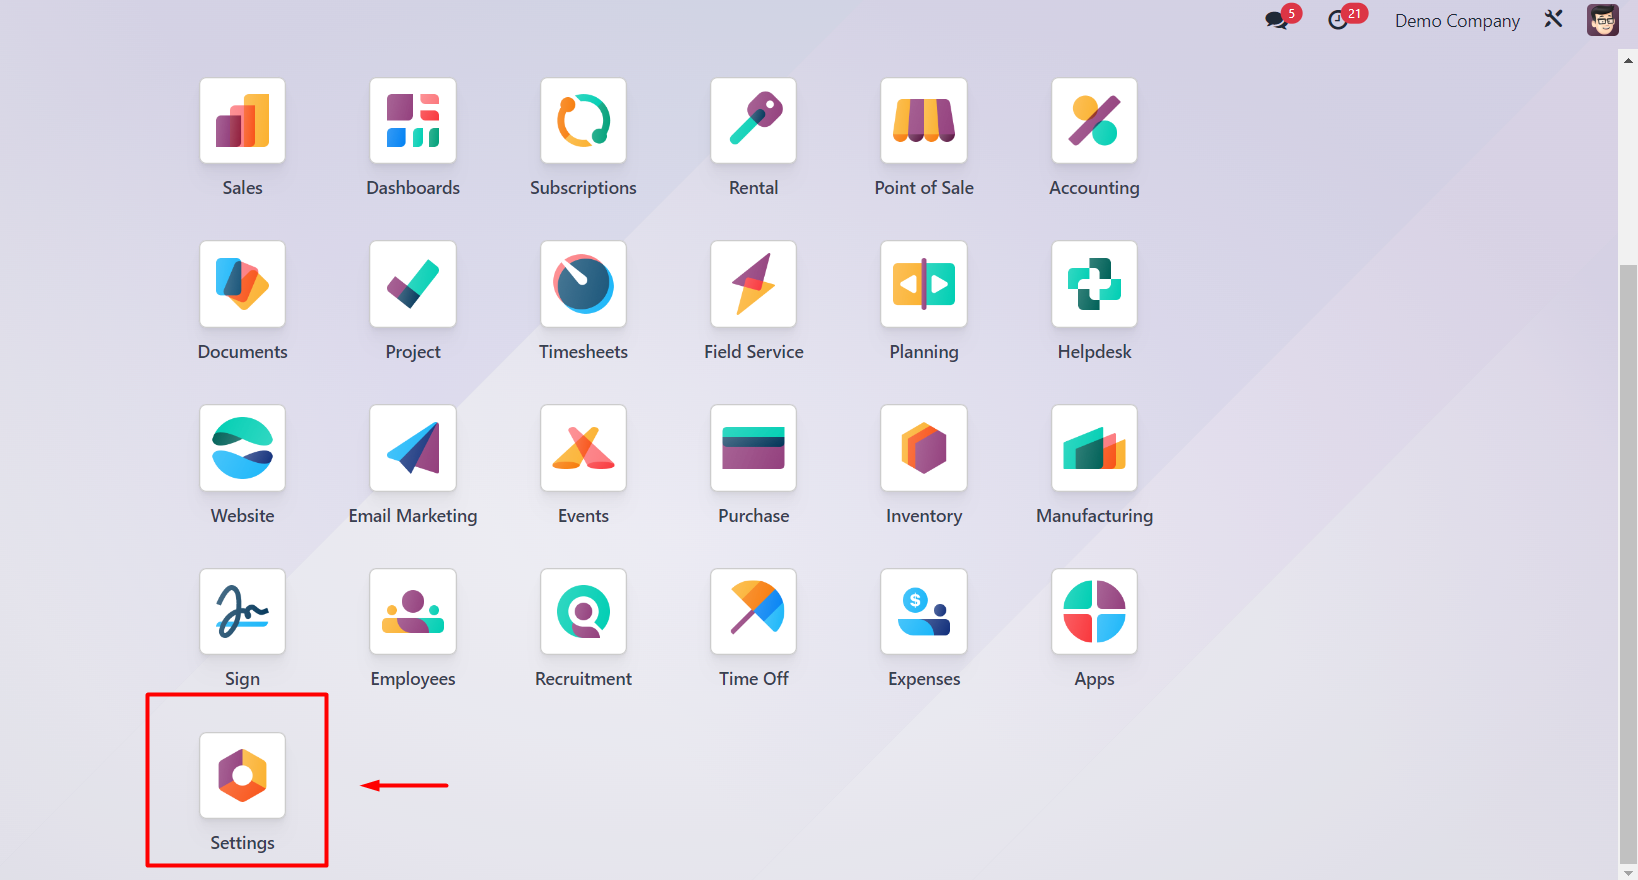




Έπειτα, τέρμα κάτω στα Developer Tools επιλέγουμε Activate the developer mode:

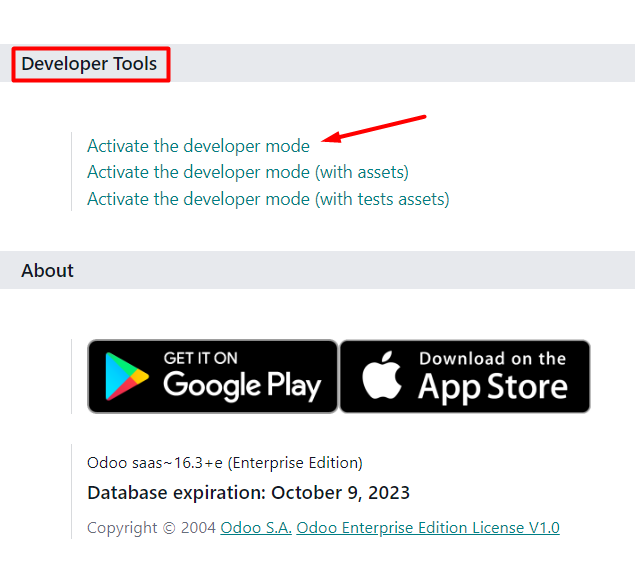

Μόλις το επιλέξουμε, το όνομα της βάσης εμφανίζεται κάτω απο το όνομα (δίπλα απο το εικονίδιο πάνω δεξιά):

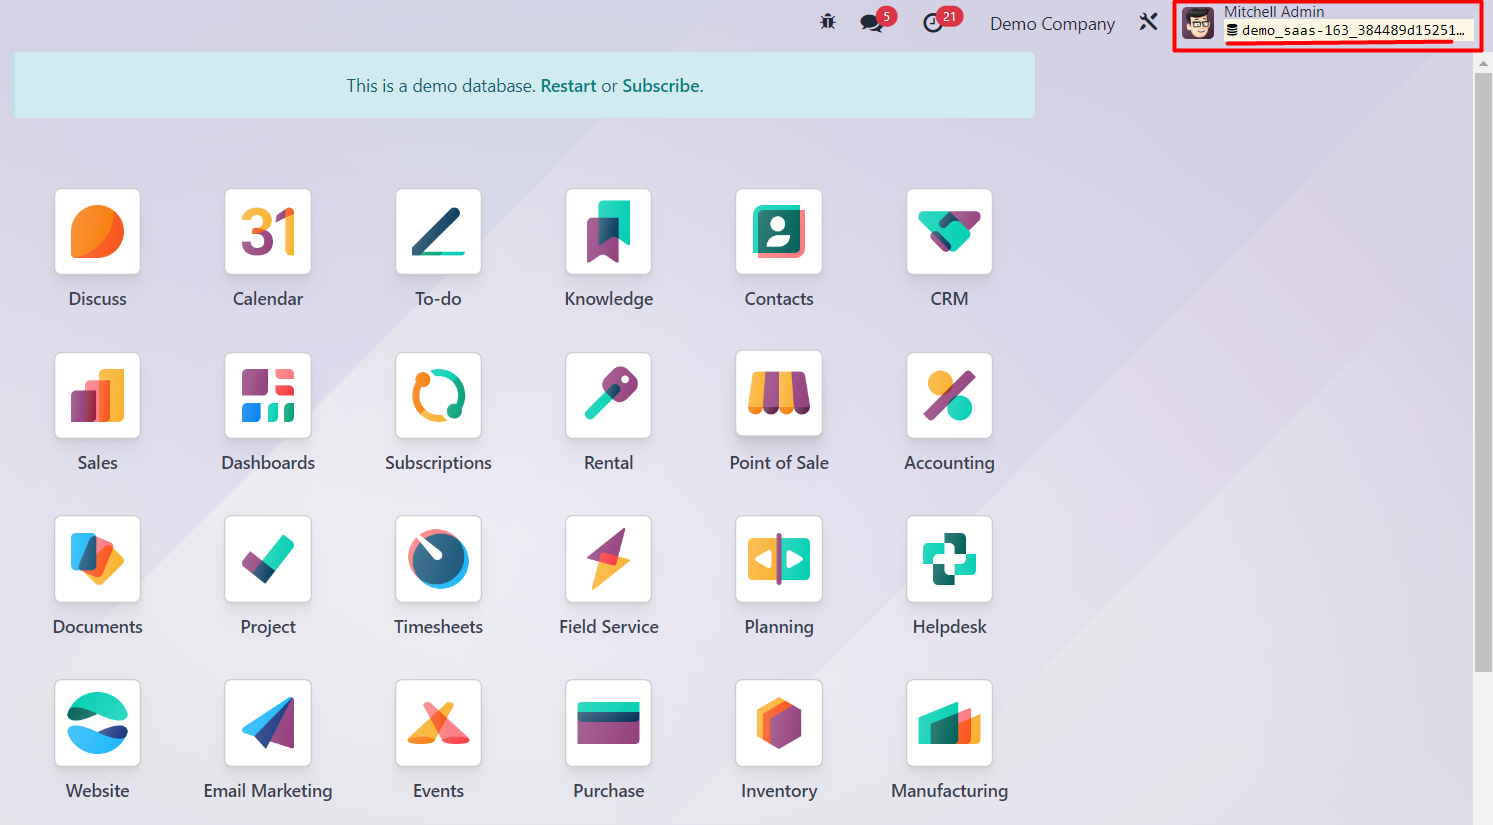

In [ ]:
import xmlrpc.client

#Task: Odoo Integration - Retrieve Product List
class OdooAPI:
    def __init__(self, url, db, username, password):
        self.url = url
        self.db = db
        self.username = username
        self.password = password
        self.common = None
        self.uid = None

    def _authenticate(self):
        #checking if the domain is valid, using version()
        try:
            self.common = xmlrpc.client.ServerProxy('{}/xmlrpc/2/common'.format(self.url)) #Create an XML-RPC proxy for the common endpoint of the Odoo server.
            version_info = self.common.version() #checking the version, if the given domain is wrong usualy it gives an ProtocolError.
        except xmlrpc.client.ProtocolError as e:
            print(f"Protocol Error: {e}")
            return None
        except Exception as e:
            print(f"Error: {e}")
            return None

        #checking if the credentials are correct
        try:
            self.uid = self.common.authenticate(self.db, self.username, self.password, {})
            if self.uid:
                print("Authentication success")
            else:
                print("Authentication failed")
            return self.uid
        except xmlrpc.client.Fault as e:
            print(f"Authentication failed: {e}")
            return None


    def fetch_products(self):
        if self.uid is None: # If we try to fetch products without having perform the authentication first.
            print("Authentication required. Call _authenticate() first.")
            return []

        models = xmlrpc.client.ServerProxy('{}/xmlrpc/2/object'.format(self.url)) # This proxy will be used for performing operations on specific Odoo models.
        # Searching products
        product_ids = models.execute_kw(
        self.db, self.uid, self.password, 'product.product', 'search',
        [[['type', '=', 'product']]]  # You can add more search criteria here.
        )
        # Fetch product details (name and price) for each product.
        products = models.execute_kw(
            self.db, self.uid, self.password, 'product.product', 'read',
            [product_ids],
            {'fields': ['name', 'list_price']}  # You can specify more fields if needed.
        )
        self.display_products(products)

    # display the products with their prices.
    def display_products(self,products):
        if products:
            print("#####################################################################")
            for product in products:
                print(f"Product Name: {product['name']}, Price: {product['list_price']}")
            print("#####################################################################")
        else:
            print("There is no products")

# This method create an OdooAPI instance performs the authentication and prints out all the products (if any exist).
def test_instace(url, db, username, password):
    # Create an instance of the OdooAPI class.
    odoo_api = OdooAPI(url, db, username, password)

    # Authenticate with the Odoo instance.
    odoo_api._authenticate()

    # Check if authentication was successful.
    if odoo_api.uid:
        # Fetch and display product data.
        odoo_api.fetch_products()

if __name__ == "__main__":
    #change the following to your to run it correctly
    #1 Test the demo instance
    url = 'https://demo6.odoo.com'  # Use the base URL.
    db = 'demo_saas-163_dc102a4707b6_1694256244'  # Database name for the demo instance .
    username = 'admin'
    password= 'admin'

    test_instace(url, db, username, password)

    #2 Test my instance with 0 products.
    url = 'https://mycompany8.odoo.com'
    db = 'mycompany8'
    username = 'xxx@gmail.com'
    password = 'adminn'

    test_instace(url, db, username, password)


Authentication success
#####################################################################
Product Name: Customizable Desk, Price: 750.0
Product Name: Customizable Desk, Price: 750.0
Product Name: Corner Desk Right Sit, Price: 147.0
Product Name: Large Cabinet, Price: 320.0
Product Name: Storage Box, Price: 15.8
Product Name: Large Desk, Price: 1799.0
Product Name: Pedal Bin, Price: 47.0
Product Name: Cabinet with Doors, Price: 140.0
Product Name: Conference Chair, Price: 33.0
Product Name: Conference Chair, Price: 33.0
Product Name: Desk Organizer, Price: 5.1000000000000005
Product Name: Desk Pad, Price: 1.98
Product Name: LED Lamp, Price: 0.9
Product Name: Letter Tray, Price: 4.8
Product Name: Magnetic Board, Price: 1.98
Product Name: Monitor Stand, Price: 3.19
Product Name: Newspaper Rack, Price: 1.28
Product Name: Small Shelf, Price: 2.83
Product Name: Wall Shelf Unit, Price: 1.98
Product Name: Customizable Desk, Price: 750.0
Product Name: Customizable Desk, Price: 750.0
Product 

Ξαναγράφω εδώ το output σε περίπτωση που χαθεί:

Authentication success
#####################################################################

Product Name: Customizable Desk, Price: 750.0

Product Name: Customizable Desk, Price: 750.0

Product Name: Corner Desk Right Sit, Price: 147.0

Product Name: Large Cabinet, Price: 320.0

Product Name: Storage Box, Price: 15.8

Product Name: Large Desk, Price: 1799.0

Product Name: Pedal Bin, Price: 47.0

Product Name: Cabinet with Doors, Price: 140.0

Product Name: Conference Chair, Price: 33.0

Product Name: Conference Chair, Price: 33.0

Product Name: Desk Organizer, Price: 5.1000000000000005

Product Name: Desk Pad, Price: 1.98

Product Name: LED Lamp, Price: 0.9

Product Name: Letter Tray, Price: 4.8

Product Name: Magnetic Board, Price: 1.98

Product Name: Monitor Stand, Price: 3.19

Product Name: Newspaper Rack, Price: 1.28

Product Name: Small Shelf, Price: 2.83

Product Name: Wall Shelf Unit, Price: 1.98

Product Name: Customizable Desk, Price: 750.0

Product Name: Customizable Desk, Price: 750.0

Product Name: Customizable Desk, Price: 750.0

Product Name: Office Chair Black, Price: 120.5

Product Name: Individual Workplace, Price: 885.0

Product Name: Corner Desk Left Sit, Price: 85.0

Product Name: Drawer Black, Price: 24.0

Product Name: Table Leg, Price: 50.0

Product Name: Cable Management Box, Price: 100.0

Product Name: Drawer Case Black, Price: 20.0

Product Name: Acoustic Bloc Screens, Price: 295.0

Product Name: Large Meeting Table, Price: 4000.0

Product Name: Wood Panel, Price: 100.0

Product Name: Ply Layer, Price: 10.0

Product Name: Office Chair, Price: 70.0

Product Name: Desk Combination, Price: 450.0

Product Name: Desk Stand with Screen, Price: 2100.0

Product Name: Wear Layer, Price: 10.0

Product Name: Four Person Desk, Price: 2350.0

Product Name: Table Top, Price: 380.0

Product Name: Plastic Laminate, Price: 1000.0

Product Name: Drawer, Price: 110.5

Product Name: Office Lamp, Price: 40.0

Product Name: Drawer Black, Price: 25.0

Product Name: Three-Seat Sofa, Price: 1500.0

Product Name: Flipover, Price: 1950.0

Product Name: Ply Veneer, Price: 10.0

Product Name: Table, Price: 520.0

Product Name: Office Design Software, Price: 280.0

Product Name: Printer, Price: 1.0

Product Name: Plastic Mug (SUB), Price: 0.0

Product Name: Whiteboard, Price: 1.7

#####################################################################

Authentication success

There is no products